In [25]:
#Sources used to build the neural network include the following: 
#Lecture 6, Discussion 4, Discussion 5 and the following Github Repositories: (FMA) https://github.com/mdeff/fma and (Music Classification) https://github.com/saiteki-kai/music-classification

import numpy as np
import pandas as pd
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import utils
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from keras import layers, Sequential, callbacks
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline
from nn import plot_history
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [26]:
#Load the fma archive data set by declaring tracks and features

tracks = utils.load('tracks.csv')
features = utils.load('features.csv')
#tracks.drop(tracks[tracks('track', 'genre_top') == ''].index, inplace = True)

In [27]:
#Process the data set
#Here we are using the small data set

subset = tracks['set', 'subset'] <= 'small'
#subset = tracks.index[tracks['set', 'subset'] <= 'medium']
train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

y_train = tracks.loc[subset & train, ("track", "genre_top")]
y_val = tracks.loc[subset & val, ("track", "genre_top")]
y_test = tracks.loc[subset & test, ("track", "genre_top")]

X_train = features.loc[subset & train]
X_val = features.loc[subset & val]
X_test = features.loc[subset & test]

y_train = y_train.astype(pd.CategoricalDtype(categories=["Rock", "Pop", "Folk", "Hip-Hop", "Electronic", "Experimental", "Instrumental", "International"]))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
y_train_values = y_train.value_counts()
y_train_attributes = list(y_train.unique())
y_length = len(y_train_values)

In [28]:
#Normalize the data set using StandardScaler()

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_val = lab_encoder.transform(y_val)
y_test = lab_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, 8)
y_val = tf.keras.utils.to_categorical(y_val, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [29]:
#Using optimal parameters (512, 256) to build the NN yielding the highest accuracy 
tf.keras.backend.clear_session()

model = Sequential([layers.Dense(512, input_shape=(518,), activation="relu", kernel_regularizer=l2(0.02)), layers.Dense(256, activation="relu", kernel_regularizer=l2(0.02)), layers.Dense(y_length, activation="softmax", kernel_regularizer=l2(0.02))])
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])
sequential_model = model.summary()

print(sequential_model)

batch_size = 32
epochs=200
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit( X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               265728    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
Total params: 399,112
Trainable params: 399,112
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
200/200 [==============================] - 5s 9ms/step - loss: 16.9451 - accuracy: 0.4122 - val_loss: 14.7280 - val_accuracy: 0.4963
Epoch 2/200
200/200 [==============================] - 4s 21ms/step - loss: 12.8356 - accuracy: 0.5533 - val_loss: 11.2996 - val_accuracy: 0.5113
Epoch 3/200
200/200 [==============================] - 9s 45ms/step - loss: 9.7693 -

25/25 [==============================] - 0s 3ms/step - loss: 1.9202 - accuracy: 0.4837


c:\Users\arman\Documents\ECS 171 ML Project\ML G\music-classification-master\notebooks\nn.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NameError: name 'classes' is not defined

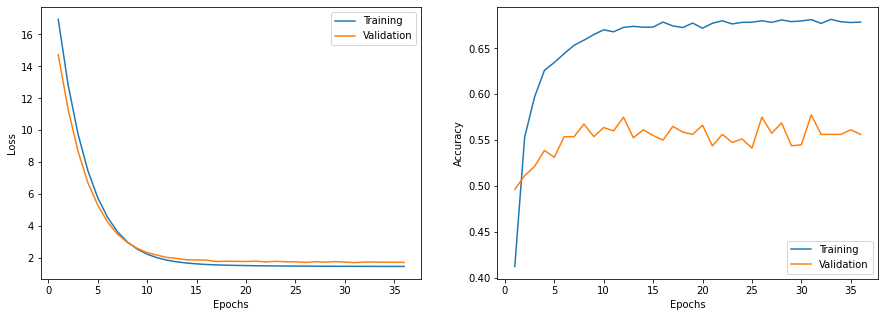

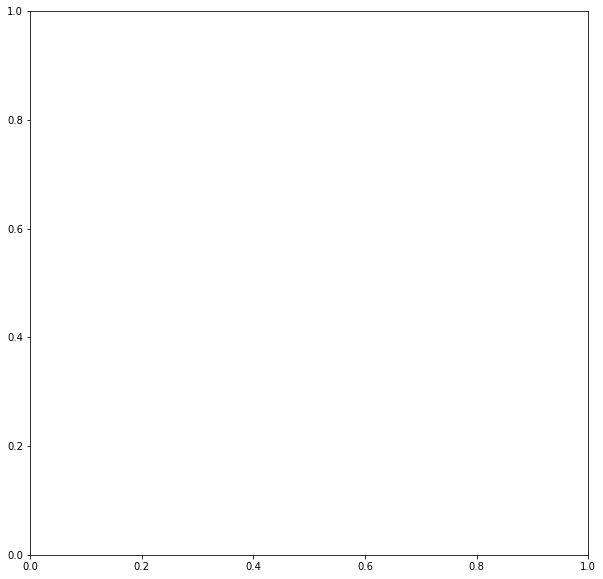

In [30]:
#Plot the Loss and Accuracy Functions
plot_history(history.history)
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

#Display the Confusion Matrix
y_pred = model.predict(X_test, batch_size=batch_size)
c_matrix = confusion_matrix(np.argmax(y_pred, 1), np.argmax(y_test, 1))
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(c_matrix, display_labels=classes)
disp.plot(ax=ax, xticks_rotation=90, cmap = 'Blues')